In [1]:
import os
import shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
if not os.path.exists('/kaggle/working/dataset'):
    os.mkdir('/kaggle/working/dataset')

In [3]:
for folder in os.listdir("/kaggle/input/fruits-classification"):
    old_path = os.path.join("/kaggle/input/fruits-classification", folder)
    new_name = folder.replace("downloaded_images_", "")
    new_path = os.path.join("/kaggle/working/dataset", new_name)
    #os.rename(old_path, new_path)
    shutil.copytree(old_path, new_path)

In [20]:
import tensorflow as tf

batch_size = 32
img_size = (180, 180)

# Load training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 2270 files belonging to 10 classes.
Using 1816 files for training.
Found 2270 files belonging to 10 classes.
Using 454 files for validation.
Classes: ['Lychee', 'apple', 'banana', 'date', 'grapes', 'kiwi', 'mango', 'orange', 'pineapple', 'watermelon']


In [21]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


**Custom Model**

In [22]:
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create a directory to store weights
os.makedirs("/kaggle/working/checkpoints", exist_ok=True)

callbacks = [
    # Stop if val_loss doesn't improve for 3 consecutive epochs
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),

    # Save weights of each epoch
    ModelCheckpoint(
        filepath='/kaggle/working/checkpoints/weights_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.h5',
        #save_weights_only=True,
        save_weights_only=False,
        save_best_only=False,
        verbose=1
    )
]


In [24]:
#model.load_weights("/kaggle/working/checkpoints/weights_epoch_07_val_loss_0.25.h5")


In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1326 - loss: 2.5682
Epoch 1: saving model to /kaggle/working/checkpoints/weights_epoch_01_val_loss_1.77.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.1347 - loss: 2.5572 - val_accuracy: 0.4119 - val_loss: 1.7690
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3409 - loss: 1.8139
Epoch 2: saving model to /kaggle/working/checkpoints/weights_epoch_02_val_loss_1.47.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3416 - loss: 1.8125 - val_accuracy: 0.5110 - val_loss: 1.4721
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4475 - loss: 1.5896
Epoch 3: saving model to /kaggle/working/checkpoints/weights_epoch_03_val_loss_1.34.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4479 - loss: 1.5884 - val_accuracy: 0.5352 - val_loss: 1.3409
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5193 - loss: 1.4108
Epoch 4: saving model to /kaggle/working/checkpoint

In [26]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(path):
    img = load_img(path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    print(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")


In [31]:
predict_image("/kaggle/input/fruits-classification/downloaded_images_kiwi/img_119.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted: kiwi (80.80%)


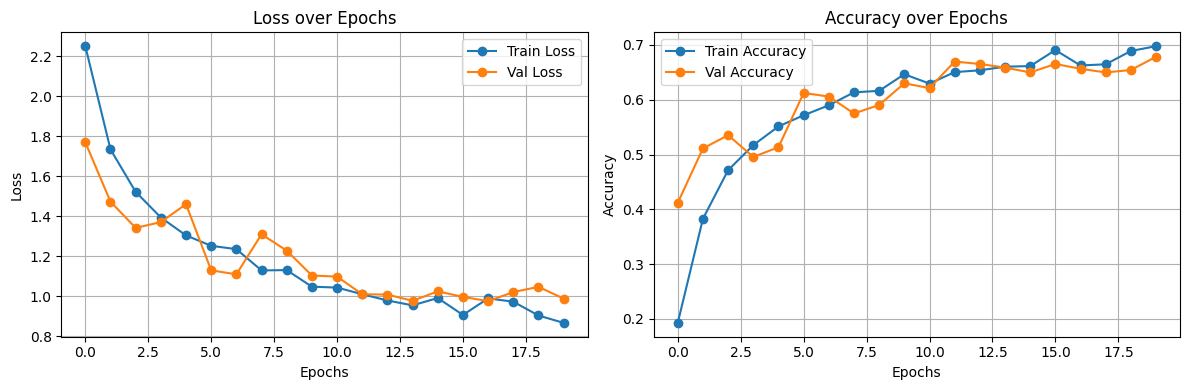

In [32]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**MobileNet with Transfer Learning**

In [37]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(180, 180, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model1 = tf.keras.Sequential([
    layers.Input(shape=(180, 180, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [38]:
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5057 - loss: 1.5443
Epoch 1: saving model to /kaggle/working/checkpoints/weights_epoch_01_val_loss_0.39.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 105ms/step - accuracy: 0.5087 - loss: 1.5348 - val_accuracy: 0.8656 - val_loss: 0.3871
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8429 - loss: 0.4642
Epoch 2: saving model to /kaggle/working/checkpoints/weights_epoch_02_val_loss_0.27.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8431 - loss: 0.4640 - val_accuracy: 0.9053 - val_loss: 0.2659
Epoch 3/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8829 - loss: 0.3498
Epoch 3: saving model to /kaggle/working/checkpoints/weights_epoch_03_val_loss_0.29.h5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8830 - loss: 0.3490 - val_accuracy: 0.8943 - val_loss: 0.2946
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9083 - loss: 0.2801
Epoch 4: saving model to /kaggle/working/checkpoi

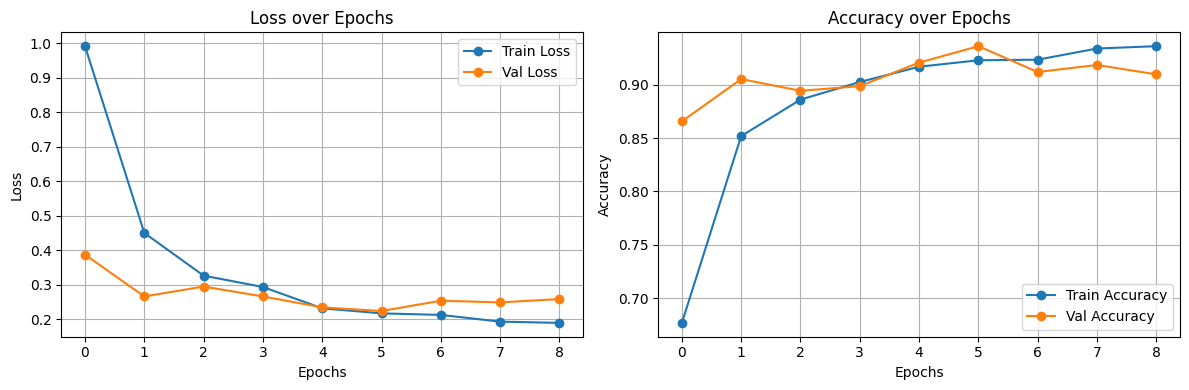

In [39]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss', marker='o')
plt.plot(history1.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [40]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/test-fruit-classification/test",
    image_size=(180, 180),
    batch_size=32,
    shuffle=False  # Don't shuffle so labels align for metrics
)


Found 56 files belonging to 10 classes.


In [41]:
loss, accuracy = model1.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2128 - loss: 7.5238
Test Accuracy: 30.36%
Test Loss: 6.2252


In [42]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1652 - loss: 3.7927
Test Accuracy: 23.21%
Test Loss: 3.3435


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
              precision    recall  f1-score   support

       apple       0.00      0.00      0.00         7
      banana       0.00      0.00      0.00         6
        date       0.00      0.00      0.00         7
      grapes       0.10      0.20      0.13         5
        kiwi       0.00      0.00      0.00         6
      lychee       0.00      0.00      0.00         5
       mango       0.75      0.75      0.75         4
      orange       1.00      0.83      0.91         6
   pineapple       1.00      1.00      1.00         4
  watermelon       1.00      0.67      0.80         6

    accuracy                           0.30        56
   macro avg       0.39      0.34      0.36        56
weighted avg       0.35      0.30      0.32        56



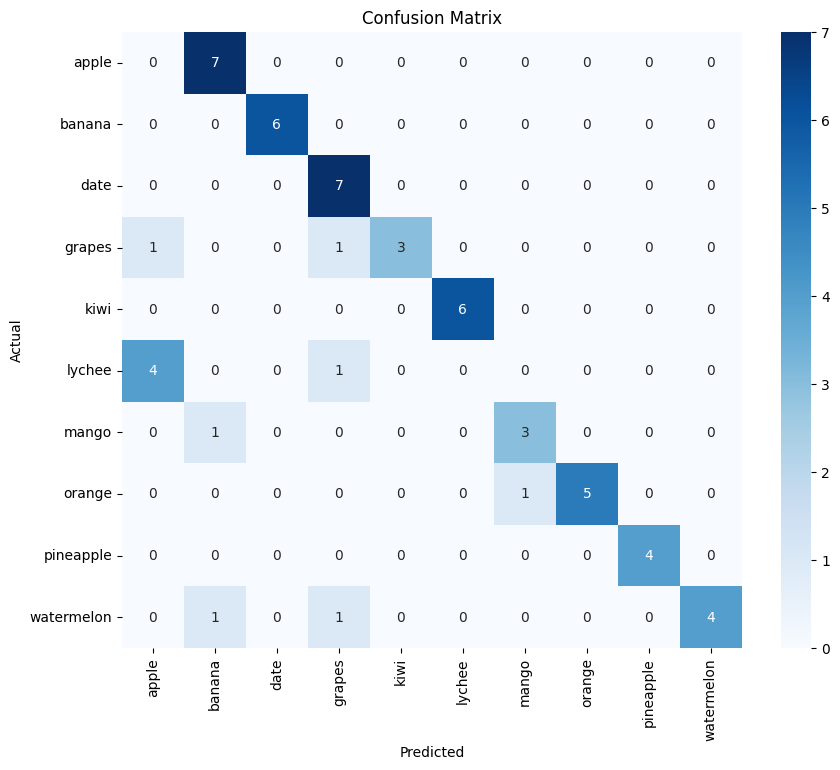

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test data
y_pred_probs = model1.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
